In [35]:
# install package needed for SMOTE
!pip install imblearn
# install package for tree visualization
!pip install graphviz

41941.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
41951.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [36]:
# load dependencies
import pandas as pd # for importing and handling data
import numpy as np # for working with arrays
from sklearn.model_selection import train_test_split # for splitting data
from imblearn.over_sampling import SMOTE # for smote oversampling

# imports from other code file (figure out what does what later)
import math
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, roc_auc_score
from scipy.stats import pearsonr

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [37]:
# load data (you might have to change the filepath -- my project files are in a sub-folder called final_project)
seed = 2001

df = pd.read_csv("/home/jupyter/final_project/pisa_median.csv")
df.head()

,Unnamed: 0,ST352Q06JA,AGE,ST004D01T,DURECEC,REPEAT,MISSSC,SKIPPING,TARDYSD,EXPECEDU,...,ST353Q07JA,ST353Q08JA,ST348Q01JA,ST348Q02JA,ST348Q03JA,ST348Q04JA,ST348Q05JA,ST348Q06JA,ST348Q07JA,ST348Q08JA
0,1.0,2.0,15.58,1.0,2.0,0.0,0.0,1.0,2.0,7.0,...,2.0,2.0,4.0,4.0,4.0,3.0,4.0,3.0,2.0,2.0
1,2.0,2.0,16.17,2.0,2.0,0.0,1.0,0.0,1.0,7.0,...,4.0,4.0,2.0,3.0,2.0,3.0,4.0,4.0,4.0,4.0
2,3.0,4.0,15.58,2.0,0.0,0.0,0.0,0.0,0.0,9.0,...,2.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0
3,4.0,4.0,15.42,2.0,2.0,0.0,0.0,0.0,0.0,4.0,...,1.0,2.0,1.0,3.0,4.0,1.0,4.0,1.0,2.0,1.0
4,5.0,2.0,15.75,2.0,1.0,0.0,0.0,0.0,0.0,8.0,...,2.0,2.0,1.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0


In [38]:
# split into target and features
y = df["ST352Q06JA"].values
X = df.drop(["ST352Q06JA"], axis=1).values

In [39]:
# split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, # common to use 20-30% of data as test set
                                                    random_state = seed, # set seed equivalent
                                                    stratify = y) # outcome amounts equal in train and test

In [40]:
# frequency of observations in training data pre-oversampling -- THIS BLOCK CAN BE DELETED
temp = y_train.astype(int)
np.bincount(temp)

array([   0, 1349, 2325, 2088, 3182])

In [41]:
# conduct oversampling on training data using SMOTE
# SMOTE overview here: https://www.youtube.com/watch?v=1Ic7GRtDrPM
smote = SMOTE(random_state = seed)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [42]:
# frequency of observations in training data post-oversampling -- THIS BLOCK CAN BE DELETED
temp2 = y_smote.astype(int)
np.bincount(temp2)

array([   0, 3182, 3182, 3182, 3182])

In [43]:
# define the parameter grid for hyperparameter tuning
param_grid = {'n_estimators': [50, 250, 450, 650],
              'max_depth': [1,4,7,10],
              'max_features': [20, 50, 80, 110, 140]}

# create a random forest regressor
rf = RandomForestClassifier(random_state=seed)

In [44]:
k_folds = KFold(n_splits=5, shuffle=True, random_state=seed)

In [11]:
# Create a GridSearchCV object
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring = 'neg_mean_squared_error',
    cv=k_folds, 
    return_train_score=True,
    verbose=1)

# Fit the random search object to the data
grid_rf.fit(X_smote, y_smote)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2001, shuffle=True),
             estimator=RandomForestClassifier(random_state=2001),
             param_grid={'max_depth': [1, 4, 7, 10],
                         'max_features': [20, 50, 80, 110, 140],
                         'n_estimators': [50, 250, 450, 650]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [12]:
print("\n The best score across ALL searched params:\n", grid_rf.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_rf.best_params_)


 The best score across ALL searched params:
 -0.8895362192244237

 The best parameters across ALL searched params:
 {'max_depth': 10, 'max_features': 20, 'n_estimators': 250}


In [13]:
# convert results to pandas df
cv_results_dict = pd.DataFrame.from_dict(grid_rf.cv_results_)
 
# write to csv for future reference
cv_results_dict.to_csv("/home/jupyter/final_project/rf_cv_results.csv")

In [45]:
# read csv of results (so you don't have to run hyperparameter tuning again)
hyperparams = pd.read_csv("rf_cv_results.csv")

# get best hyperparameters
print(hyperparams[hyperparams["rank_test_score"] == 1])
max_features = hyperparams[hyperparams["rank_test_score"] == 1]["param_max_features"].values[0]
n_estimators =  hyperparams[hyperparams["rank_test_score"] == 1]["param_n_estimators"].values[0]
max_depth = hyperparams[hyperparams["rank_test_score"] == 1]["param_max_depth"].values[0]

    Unnamed: 0  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
61          61      23.689694      0.324684         0.120937        0.003507   

    param_max_depth  param_max_features  param_n_estimators  \
61               10                  20                 250   

                                               params  split0_test_score  ...  \
61  {'max_depth': 10, 'max_features': 20, 'n_estim...          -0.835821  ...   

    mean_test_score  std_test_score  rank_test_score  split0_train_score  \
61        -0.889536        0.027759                1           -0.499116   

    split1_train_score  split2_train_score  split3_train_score  \
61           -0.501866           -0.472304           -0.488167   

    split4_train_score  mean_train_score  std_train_score  
61           -0.509477         -0.494186         0.012901  

[1 rows x 24 columns]


In [46]:
print(max_features, n_estimators, max_depth)

20 250 10


In [47]:
# fit cross_val with best estimator in training data to get various outcomes beyond rmse
# instantiate classifier
clf = RandomForestClassifier(n_estimators = n_estimators,
                        max_features = max_features,
                        max_depth = max_depth,
                        random_state = seed)

# fit classifier to training data
clf.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=10, max_features=20, n_estimators=250,
                       random_state=2001)

In [49]:
# fit cross_val to test data, get predicted values
# cross_val KFold object created earlier
# could replace this with cross_validation to get multiple scores at once
# train_scores = cross_val_score(clf, X_smote, y_smote, cv=cross_val)
train_scores = cross_validate(clf,
                              X_smote,
                              y_smote,
                              cv = k_folds,
                              scoring = ["neg_mean_squared_error", "f1_micro", "neg_root_mean_squared_error", "neg_mean_absolute_error", "roc_auc_ovr", "precision_micro", "recall_micro"],
                              return_train_score = True)

train_scores

{'fit_time': array([22.13302183, 21.80778241, 22.11107326, 22.11308694, 22.19904566]),
 'score_time': array([0.28812909, 0.24907446, 0.30323815, 0.34686232, 0.26253557]),
 'test_neg_mean_squared_error': array([-0.8358209 , -0.90219953, -0.91358995, -0.89155206, -0.90451866]),
 'train_neg_mean_squared_error': array([-0.49911609, -0.50186604, -0.47230407, -0.48816655, -0.50947658]),
 'test_f1_micro': array([0.63550668, 0.61076198, 0.62372349, 0.63418468, 0.61886051]),
 'train_f1_micro': array([0.78236103, 0.77420939, 0.78520919, 0.78130217, 0.77383875]),
 'test_neg_root_mean_squared_error': array([-0.91423241, -0.94984184, -0.95581899, -0.94422035, -0.95106186]),
 'train_neg_root_mean_squared_error': array([-0.70648148, -0.70842504, -0.68724382, -0.69868917, -0.71377628]),
 'test_neg_mean_absolute_error': array([-0.50903378, -0.54399057, -0.53731343, -0.52141454, -0.53595285]),
 'train_neg_mean_absolute_error': array([-0.3024946 , -0.3103516 , -0.29395011, -0.30138466, -0.31208878]),
 't

In [50]:
# f1 score
print(f"Training F1 score: {(train_scores['train_f1_micro']).mean()}")
print(f"Validation F1 score: {(train_scores['test_f1_micro']).mean()}")
print(f"Validation F1 SD: {(train_scores['test_f1_micro']).std()}\n")

# precision (of all instances labelled as positive, how many were actually positive?)
print(f"Training precision score: {(train_scores['train_precision_micro']).mean()}")
print(f"Validation precision score: {(train_scores['test_precision_micro']).mean()}")
print(f"Validation precision SD: {(train_scores['test_precision_micro']).std()}\n")

# recall (of all actual positive instances, how many were correctly classified?)
print(f"Training recall score: {(train_scores['train_recall_micro']).mean()}")
print(f"Validation recall score: {(train_scores['test_recall_micro']).mean()}")
print(f"Validation recall SD: {(train_scores['test_recall_micro']).std()}\n")

# mean squared error
print(f"Training MSE score: {(-1*train_scores['train_neg_mean_squared_error']).mean()}")
print(f"Validation MSE score: {(-1*train_scores['test_neg_mean_squared_error']).mean()}")
print(f"Validation MSE SD: {(-1*train_scores['test_neg_mean_squared_error']).std()}\n")

# root mean squared error
print(f"Training RMSE score: {np.sqrt(-1*train_scores['train_neg_mean_squared_error']).mean()}")
print(f"Validation RMSE score: {np.sqrt(-1*train_scores['test_neg_mean_squared_error']).mean()}")
print(f"Validation RMSE SD: {np.sqrt(-1*train_scores['test_neg_mean_squared_error']).std()}\n")

# mean absolute error
print(f"Training MAE score: {(-1*train_scores['train_neg_mean_absolute_error']).mean()}")
print(f"Validation MAE score: {(-1*train_scores['test_neg_mean_absolute_error']).mean()}")
print(f"Validation MAE score: {(-1*train_scores['test_neg_mean_absolute_error']).std()}\n")

# ROC
print(f"Training ROC score: {(train_scores['train_roc_auc_ovr']).mean()}")
print(f"Validation ROC score: {(train_scores['test_roc_auc_ovr']).mean()}")
print(f"Validation ROC score: {(train_scores['test_roc_auc_ovr']).std()}\n")

Training F1 score: 0.779384106444291
Validation F1 score: 0.6246074662361855
Validation F1 SD: 0.00933833130121686

Training precision score: 0.779384106444291
Validation precision score: 0.6246074662361855
Validation precision SD: 0.00933833130121686

Training recall score: 0.779384106444291
Validation recall score: 0.6246074662361855
Validation recall SD: 0.00933833130121686

Training MSE score: 0.49418586440521095
Validation MSE score: 0.8895362192244237
Validation MSE SD: 0.02775901442525209

Training RMSE score: 0.7029231581039166
Validation RMSE score: 0.9430350903000642
Validation RMSE SD: 0.014867336250101901

Training MAE score: 0.30405394866556434
Validation MAE score: 0.5295410343587614
Validation MAE score: 0.012624564969122043

Training ROC score: 0.9527304062563765
Validation ROC score: 0.8501977644076861
Validation ROC score: 0.0032622859199506215



In [51]:
# get order of feature importances, sorted from least to most important
sorted_idx = clf.feature_importances_.argsort() 
sorted_idx

array([ 4,  5, 10,  9, 12, 11, 22, 20,  6, 48, 46, 47,  7, 21, 60, 61, 50,
       58, 59, 63,  3, 54, 62, 45, 52, 15, 19,  2,  8, 51, 16, 65,  1, 64,
       55, 40, 18, 53, 31, 30, 33, 29, 13, 26, 28, 36, 25, 49, 38, 27, 17,
       57, 23, 24, 37, 56,  0, 14, 32, 35, 34, 39, 42, 41, 44, 43])

In [52]:
# get best 15 indices, i.e. the last 15
top_15_idx = sorted_idx[-15:]
top_15_idx

array([57, 23, 24, 37, 56,  0, 14, 32, 35, 34, 39, 42, 41, 44, 43])

In [53]:
# get corresponding feature names
top_features = np.array(df.drop(["ST352Q06JA", "Unnamed: 0"], axis=1).columns)[top_15_idx]
top_features

array(['ST348Q01JA', 'ANXMAT', 'MATHEFF', 'ST352Q01JA', 'ST353Q08JA',
       'AGE', 'WORKPAY', 'EMPATAGR', 'FAMSUP', 'STRESAGR', 'ST352Q03JA',
       'ST352Q07JA', 'ST352Q05JA', 'ST354Q02JA', 'ST352Q08JA'],
      dtype=object)

In [54]:
# get corresponding feature importances
top_importances = clf.feature_importances_[top_15_idx]
top_importances

array([0.01291578, 0.01304604, 0.01316918, 0.01338649, 0.01351532,
       0.01355872, 0.01412844, 0.01445343, 0.01511526, 0.01976803,
       0.03759433, 0.05367735, 0.05662539, 0.11885847, 0.27898669])

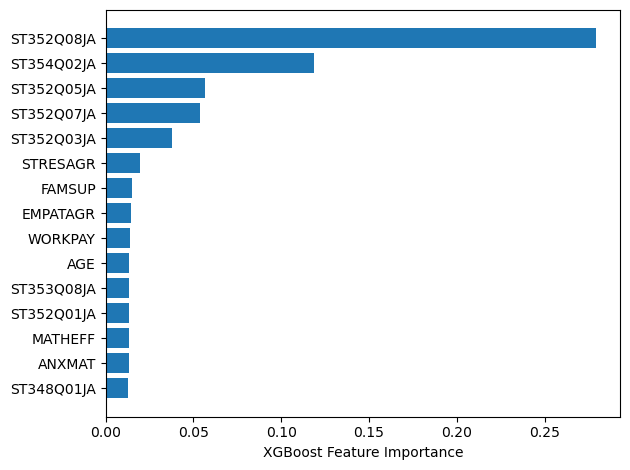

In [55]:
# plot top 15 features
plt.barh(top_features, top_importances)
plt.xlabel("XGBoost Feature Importance")
# export to png
plt.tight_layout() # prevent label cropping
plt.savefig('top_features_xgb.png', dpi=300)
plt.show()

In [57]:
# compare predicted values to actual y_test
y_pred = clf.predict(X_test)


# get outcomes of interest
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# F1 score
f1 = f1_score(y_test, y_pred, average="micro")
print(f'f1 score: {round(f1, 3)}')

# Precision
precision = precision_score(y_test, y_pred, average="micro")
print(f'precision: {round(precision, 3)}')

# Recall
recall = recall_score(y_test, y_pred, average="micro")
print(f'recall: {round(recall, 3)}')

# Mean Squared error
mse = mean_squared_error(y_test, y_pred)
print(f'mean squared error: {round(mse, 3)}')

# Root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'root mean squared error: {round(rmse, 3)}')

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'mean absolute error: {round(mae, 3)}')

# ROC curve
roc = roc_auc_score(y_test,
                    clf.predict_proba(X_test),
                    multi_class="ovr",
                    average="micro")
print(f'AUC: {round(roc, 3)}')

[[205  94   8  30]
 [ 79 381  55  67]
 [ 26 185 163 148]
 [ 58 148  82 508]]
f1 score: 0.562
precision: 0.562
recall: 0.562
mean squared error: 1.087
root mean squared error: 1.042
mean absolute error: 0.628
AUC: 0.809
